In [1]:
# Paso 1: Instalar librerías necesarias Importar librerías

!pip install gradio tldextract openpyxl --quiet # - gradio: para crear la interfaz web
                                                # - tldextract: para extraer subdominios y dominios
                                                # - openpyxl: para leer archivos Excel
import pandas as pd  # Para manejar datos en formato tabla
import numpy as np  # Para operaciones numéricas
import re  # Para usar expresiones regulares (detección de patrones en texto)
import tldextract  # Para descomponer URLs en subdominio, dominio y TLD
import joblib  # Para guardar y cargar modelos o transformadores
import gradio as gr  # Para crear una interfaz web interactiva
import datetime  # Para registrar fecha y hora en el historial
import matplotlib.pyplot as plt #Importa matplotlib para poder mostrar gráficos, como la matriz de confusión
from sklearn.model_selection import train_test_split  # Para dividir datos en entrenamiento y prueba
from sklearn.ensemble import RandomForestClassifier  # Modelo de clasificación basado en árboles
from sklearn.preprocessing import StandardScaler  # Para normalizar los datos numéricos
from sklearn.impute import SimpleImputer  # Para rellenar valores faltantes
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay  # Para evaluar el modelo
from google.colab import files  # Para subir y descargar archivos en Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00


In [2]:
# Paso 2: Subir y cargar el archivo Excel con las URLs y su clasificación
uploaded = files.upload()  # Abre una ventana para subir el archivo
file_path = list(uploaded.keys())[0]  # Obtiene el nombre del archivo subido
df = pd.read_excel(file_path)  # Lee el archivo Excel y lo guarda en un DataFrame

Saving URL.xlsx to URL.xlsx


In [3]:
# Paso 3: Convertir la columna 'type' (etiquetas) en valores numéricos
# phishing → 1, benign → 0
df['type'] = df['type'].map({'phishing': 1, 'benign': 0})

In [4]:
# Paso 4: Función que extrae características (features) de una URL
def extraer_features_desde_url(url):
    features = {
        'url_length': len(url),  # longitud total de la URL
        'num_dots': url.count('.'),  # cuántos puntos contiene
        'has_ip': 1 if re.match(r'http[s]?://\d+\.\d+\.\d+\.\d+', url) else 0,  # si contiene una dirección IP
        'has_at_symbol': 1 if '@' in url else 0,  # si contiene '@'
        'has_https': 1 if 'https' in url else 0,  # si contiene 'https'
        'has_hyphen': 1 if '-' in url else 0,  # si contiene guiones
        'num_subdomains': len(tldextract.extract(url).subdomain.split('.')) if tldextract.extract(url).subdomain else 0,
        'num_digits': sum(c.isdigit() for c in url),  # cantidad de dígitos
        'num_special_chars': sum(not c.isalnum() for c in url)  # cantidad de caracteres especiales
    }
    return features

In [5]:
# Paso 5: Aplicar la función a todas las URLs del dataset
df_features = df['URL'].apply(extraer_features_desde_url).apply(pd.Series)  # Aplica función y convierte en DataFrame
X = df_features  # Variables independientes (features)
y = df['type'].values  # Variable dependiente (objetivo: 1 o 0)
# Imputación: llenar valores faltantes con la media
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
# Escalado: normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [6]:
# Paso 6: Entrenar el modelo
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)  # 80% train, 20% test
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Crea el modelo
model.fit(X_train, y_train)  # Entrena el modelo

RandomForestClassifier(random_state=42)

In [7]:
# Paso 7: Evaluar el rendimiento del modelo
y_pred = model.predict(X_test)
print("🔎 Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📊 Reporte de clasificación:\n", classification_report(y_test, y_pred))

🔎 Matriz de confusión:
 [[71  4]
 [ 8 77]]

📊 Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92        75
           1       0.95      0.91      0.93        85

    accuracy                           0.93       160
   macro avg       0.92      0.93      0.92       160
weighted avg       0.93      0.93      0.93       160



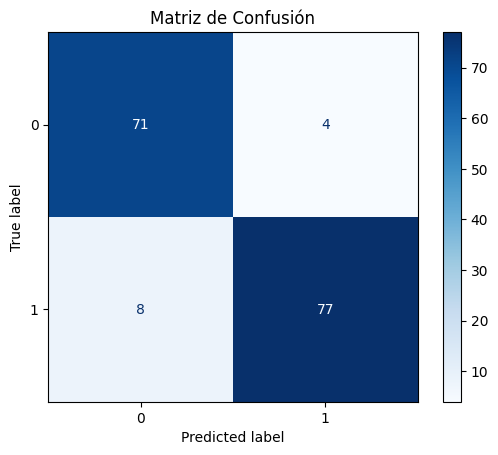

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        75
           1       0.95      0.91      0.93        85

    accuracy                           0.93       160
   macro avg       0.92      0.93      0.92       160
weighted avg       0.93      0.93      0.93       160



In [8]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar la matriz
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

# Mostrar métricas adicionales
print(classification_report(y_test, y_pred))


In [9]:
# Paso 8: Guardar el modelo y los objetos de preprocesamiento
joblib.dump(model, 'phishing_model.pkl')
joblib.dump(imputer, 'imputer.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Cargar modelo (por si se vuelve a usar más adelante)
model = joblib.load('phishing_model.pkl')
imputer = joblib.load('imputer.pkl')
scaler = joblib.load('scaler.pkl')

In [10]:
# Paso 9: Función para analizar una nueva URL
predictions_log = []  # Lista donde se guardará el historial

def detectar_phishing(url):
    try:
        features = extraer_features_desde_url(url)
        features_df = pd.DataFrame([features])
        features_imputadas = imputer.transform(features_df)
        features_escaladas = scaler.transform(features_imputadas)
        pred = model.predict(features_escaladas)

        # Resultado final
        result = "🔴 Phishing" if pred[0] == 1 else "🟢 Benigna"

        # Guardar en historial con fecha y hora
        predictions_log.append({
            "timestamp": datetime.datetime.now(),
            "url": url,
            "prediction": result
        })

        return result
    except Exception as e:
        return f"⚠️ Error al procesar: {str(e)}"

#Función para visualizar las últimas predicciones realizadas
def ver_historial():
    try:
        log_df = pd.DataFrame(predictions_log)
        return log_df.tail(20)
    except FileNotFoundError:
        return pd.DataFrame(columns=["timestamp", "url", "prediction"])

#Función para exportar el historial en CSV descargable
def descargar_historial():
    log_df = pd.DataFrame(predictions_log)
    if not log_df.empty:
        log_df.to_csv("/tmp/predictions_log.csv", index=False)
        return "/tmp/predictions_log.csv"
    else:
        return None

In [11]:
# Paso 10: Crear interfaz gráfica con Gradio
with gr.Blocks() as demo:
    gr.Markdown("# 🛡️ Detector de URLs Phishing")

    with gr.Tab("🔍 Analizar URL"):
        url_input = gr.Textbox(label="Introduce una URL")
        output = gr.Textbox(label="Resultado")
        btn = gr.Button("Analizar")
        btn.click(fn=detectar_phishing, inputs=url_input, outputs=output)

    with gr.Tab("📜 Ver historial"):
        historial_output = gr.Dataframe(label="Historial de predicciones", interactive=False)
        actualizar = gr.Button("Actualizar historial")
        actualizar.click(fn=ver_historial, outputs=historial_output)

        descargar_btn = gr.Button("Descargar historial como CSV")
        file_output = gr.File()
        descargar_btn.click(fn=descargar_historial, outputs=file_output)

# Lanzar la app
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://19026fd4a9f381577a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
